Loaded 150 frames of size 480x640.
Calculating median background and slope map...
Detecting holes based on static background (sigma=2.0)...
Found 0 potential hole(s) from static background.
Detecting activity areas (quantile=0.995)...
Found 7 potential active region(s) from slope map.
Generating visualization...


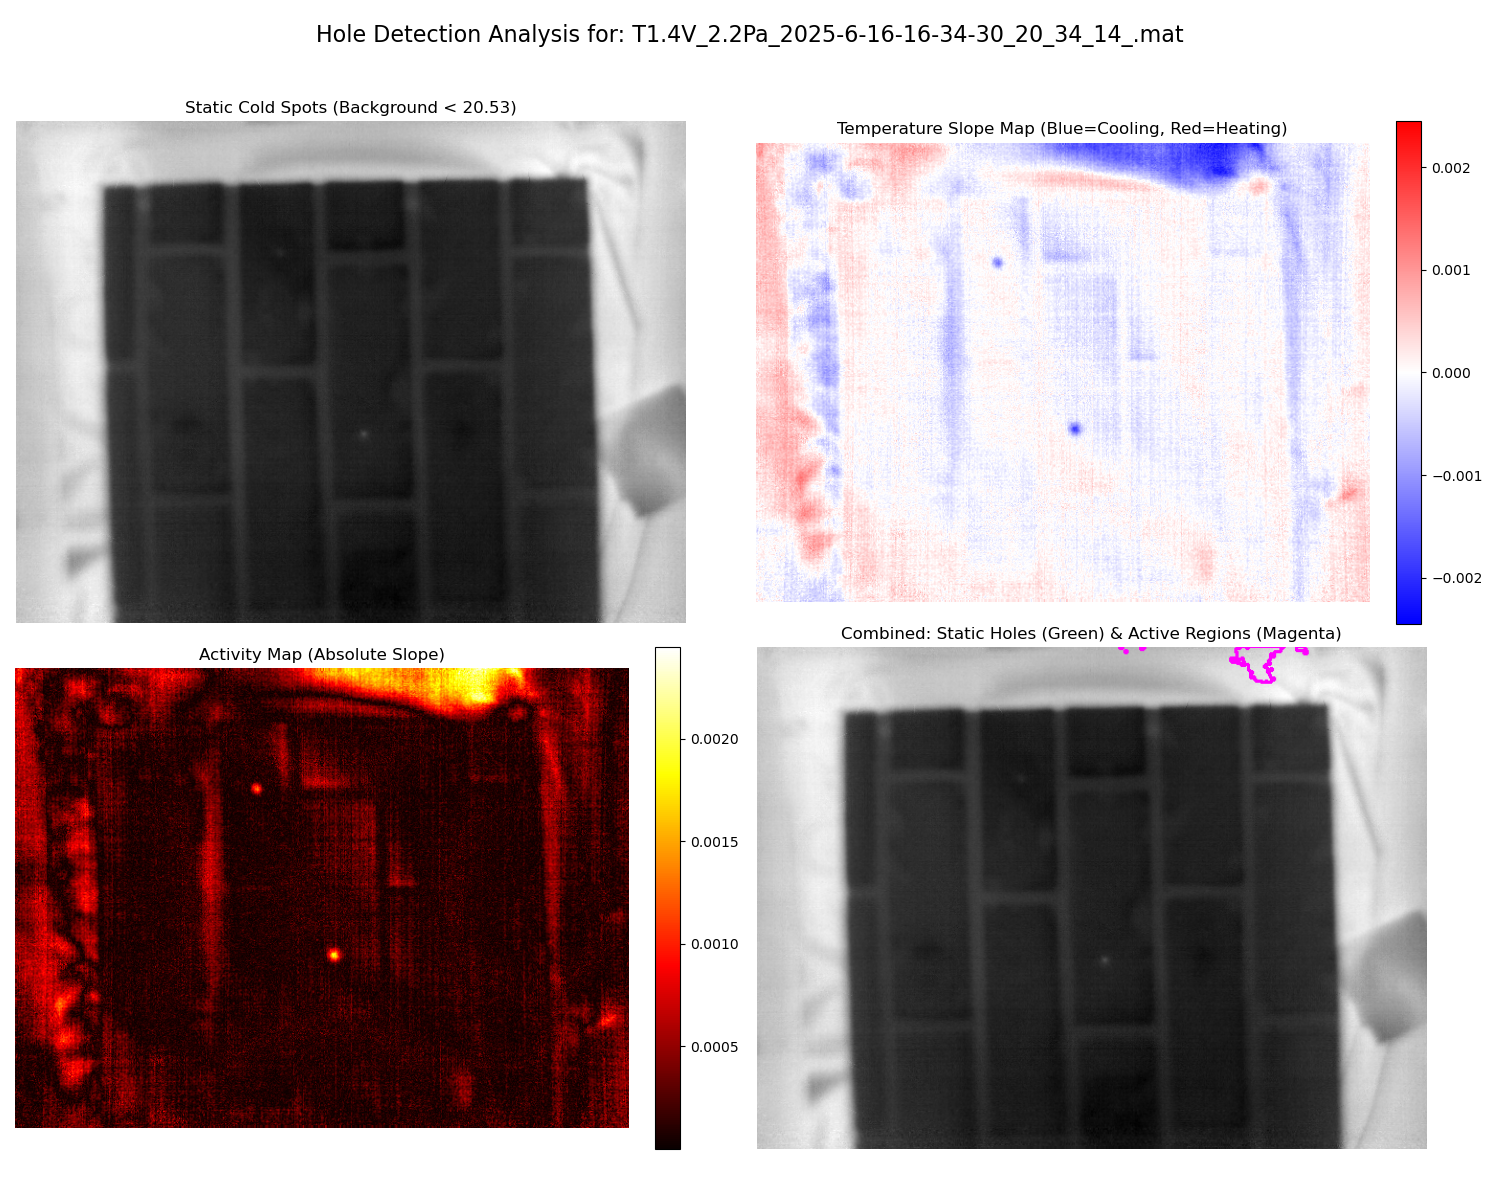

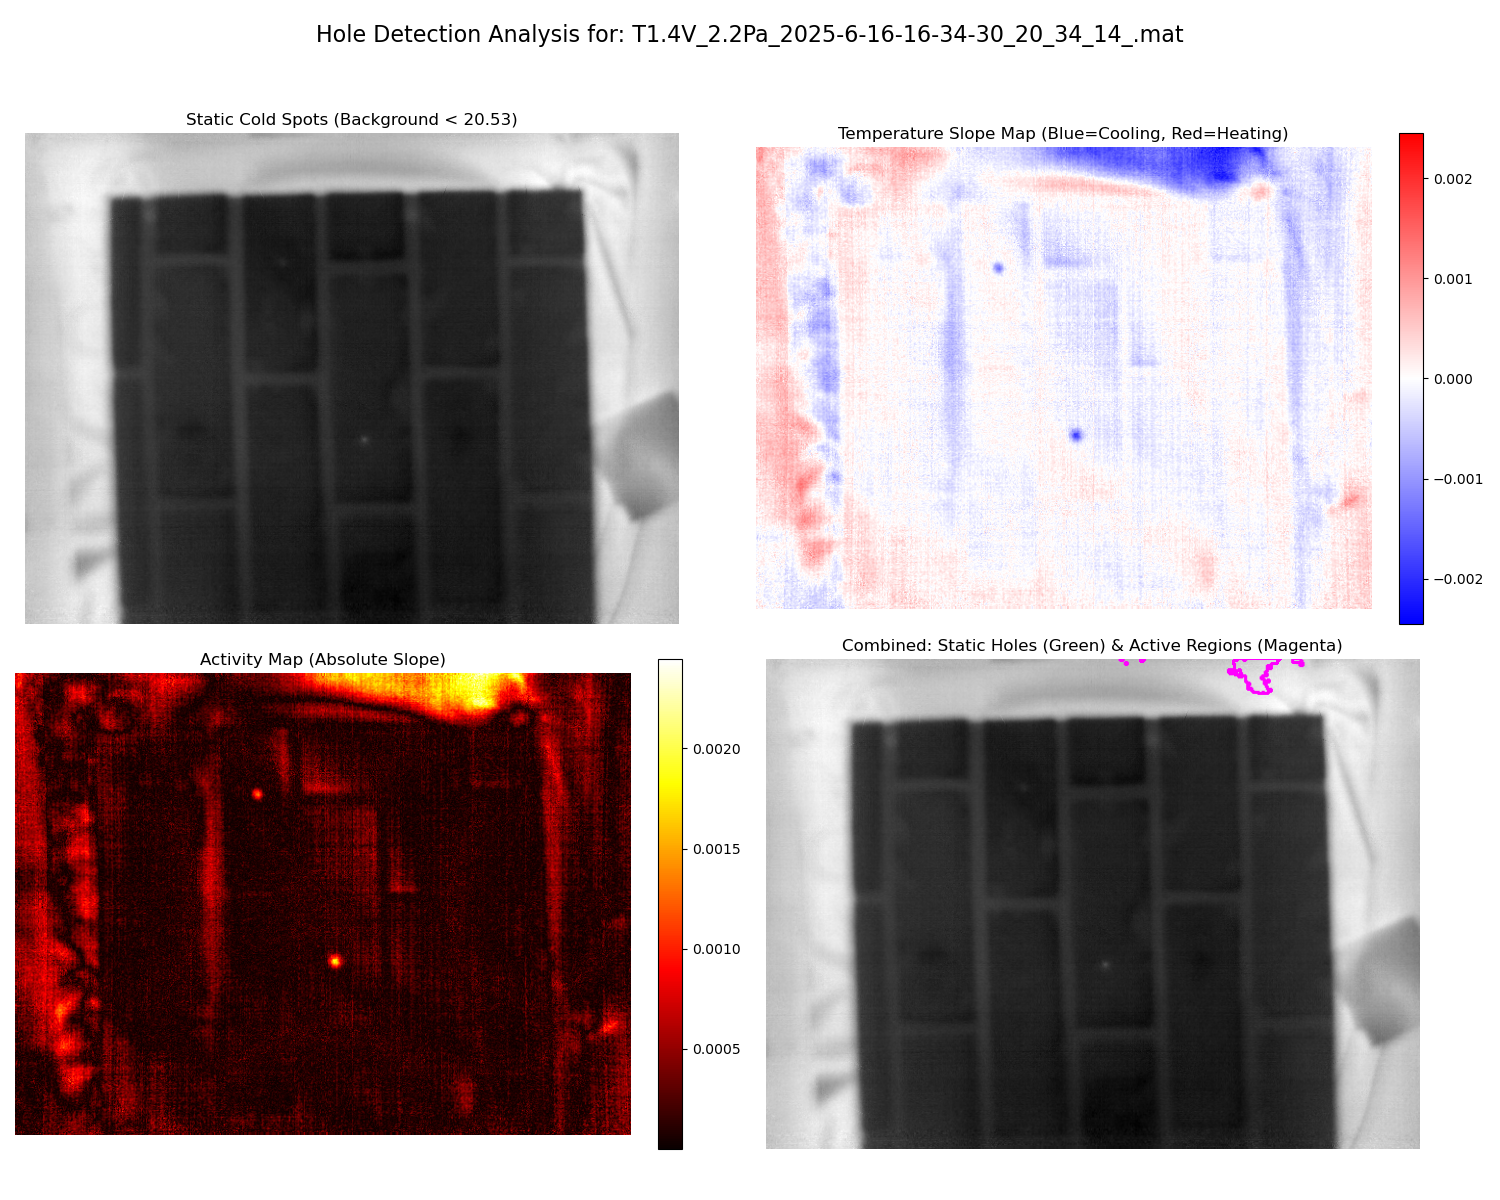

In [1]:
%matplotlib widget
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import cv2
import os
from scipy.stats import linregress

# --- Configuration ---
# Use an absolute path or ensure the script is run from the correct directory
mat_file_path = "/Users/shreyas/Desktop/UoU/Independent-Study/Airflow-rate-prediction/datasets/dataset_two_holes/T1.4V_2.2Pa_2025-6-16-16-34-30_20_34_14_.mat"

# --- Parameters to Tune ---
hole_sigma = 2.0  # Increased sigma for a stricter threshold on background temperature.
activity_quantile = 0.995 # Increased quantile to focus on only the very top activity.
morph_open_kernel_size = 5 # Kernel size for cleaning the static hole mask.
morph_activity_kernel_size = 3 # Kernel size for cleaning the activity mask.

frame_key_candidates = ['TempFrames']

# --- 1. Load Data ---
try:
    mat = scipy.io.loadmat(mat_file_path)
    # Attempt to find the right key
    for key in frame_key_candidates:
        if key in mat:
            frames = mat[key].astype(np.float64)
            break
    else:
        raise KeyError(f"None of {frame_key_candidates} found in MAT file: {mat_file_path}")
except FileNotFoundError:
    print(f"Error: MAT file not found at {mat_file_path}")
    exit()

H, W, T = frames.shape
print(f"Loaded {T} frames of size {H}x{W}.")

# --- 2. Compute Background and Slope Map ---
print("Calculating median background and slope map...")
background = np.median(frames, axis=2)

t = np.arange(T)
slope_map = np.zeros((H, W), dtype=np.float64)
# This loop can be slow for large images. It's fine for exploration.
for i in range(H):
    for j in range(W):
        # Ensure there are no NaNs in the time series for this pixel
        pixel_series = frames[i, j, :]
        if not np.any(np.isnan(pixel_series)):
            slope_map[i, j] = linregress(t, pixel_series).slope
        else:
            slope_map[i, j] = 0 # Or np.nan

# --- 3. Hole Detection via Static Background Temperature ---
# This method finds pixels that are consistently colder than the rest.
print(f"Detecting holes based on static background (sigma={hole_sigma})...")
mean_b = background.mean()
std_b = background.std()
hole_thresh = mean_b - hole_sigma * std_b
# Create a binary mask and apply morphological opening to remove small noise
hole_mask_raw = (background < hole_thresh).astype(np.uint8)
hole_mask_cleaned = cv2.morphologyEx(hole_mask_raw, cv2.MORPH_OPEN, np.ones((morph_open_kernel_size, morph_open_kernel_size), np.uint8))
# Find contours of the cleaned holes
static_hole_contours, _ = cv2.findContours(hole_mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Found {len(static_hole_contours)} potential hole(s) from static background.")

# --- 4. Activity Detection via Temperature Slope ---
# This method finds pixels where the temperature changed the most over time.
print(f"Detecting activity areas (quantile={activity_quantile})...")
abs_slope = np.abs(slope_map)
# Use only non-zero slopes to calculate the quantile to avoid being skewed by the vast background
active_pixels = abs_slope[abs_slope > 1e-9] # A small epsilon to avoid float precision issues
if active_pixels.size > 0:
    activity_threshold = np.quantile(active_pixels, activity_quantile)
    activity_mask_raw = (abs_slope >= activity_threshold).astype(np.uint8)
    # Clean up the activity mask to get more solid blobs
    activity_mask_cleaned = cv2.morphologyEx(activity_mask_raw, cv2.MORPH_OPEN, np.ones((morph_activity_kernel_size, morph_activity_kernel_size), np.uint8))
    activity_contours, _ = cv2.findContours(activity_mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Found {len(activity_contours)} potential active region(s) from slope map.")
else:
    print("No significant activity found in slope map.")
    activity_contours = []

# --- 5. Comprehensive Visualization ---
print("Generating visualization...")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f"Hole Detection Analysis for: {os.path.basename(mat_file_path)}", fontsize=16)

# Plot 1: Background Image with Static Hole Contours
# We'll draw on a color version of the background
background_display = cv2.cvtColor(cv2.normalize(background, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U), cv2.COLOR_GRAY2BGR)
cv2.drawContours(background_display, static_hole_contours, -1, (0, 255, 0), 2) # Draw contours in green
# Label the static holes
for i, c in enumerate(static_hole_contours):
    M = cv2.moments(c)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.putText(background_display, f"Hole {i+1}", (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
axes[0, 0].imshow(cv2.cvtColor(background_display, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title(f"Static Cold Spots (Background < {hole_thresh:.2f})")
axes[0, 0].axis('off')

# Plot 2: Slope Map
im1 = axes[0, 1].imshow(slope_map, cmap='bwr', vmin=-np.max(abs_slope), vmax=np.max(abs_slope)) # Centered colormap
axes[0, 1].set_title("Temperature Slope Map (Blue=Cooling, Red=Heating)")
axes[0, 1].axis('off')
fig.colorbar(im1, ax=axes[0, 1], orientation='vertical', fraction=0.046, pad=0.04)

# Plot 3: Activity Map
im2 = axes[1, 0].imshow(abs_slope, cmap='hot')
axes[1, 0].set_title(f"Activity Map (Absolute Slope)")
axes[1, 0].axis('off')
fig.colorbar(im2, ax=axes[1, 0], orientation='vertical', fraction=0.046, pad=0.04)

# Plot 4: Combined Overlay
# Start with the background image again
overlay_display = cv2.cvtColor(cv2.normalize(background, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U), cv2.COLOR_GRAY2BGR)
# Draw static hole contours in GREEN
cv2.drawContours(overlay_display, static_hole_contours, -1, (0, 255, 0), 2) # Green
# Draw activity contours in MAGENTA
cv2.drawContours(overlay_display, activity_contours, -1, (255, 0, 255), 2) # Magenta
axes[1, 1].imshow(cv2.cvtColor(overlay_display, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title("Combined: Static Holes (Green) & Active Regions (Magenta)")
axes[1, 1].axis('off')


def onclick(event):
    # only respond if you click in one of the bottom‐row axes
    if event.inaxes in (axes[1,0], axes[1,1]):
        # event.xdata is the column, event.ydata is the row in image coords
        col = int(np.round(event.xdata))
        row = int(np.round(event.ydata))
        print(f"Clicked at row={row}, col={col}")
        # you can also annotate the point on the plot if you like:
        event.inaxes.plot(col, row, 'yo')       # yellow circle
        event.inaxes.text(col, row, f"({row},{col})",
                          color='yellow', fontsize=8,
                          ha='left', va='bottom')
        fig.canvas.draw()

# connect the click handler
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Normalized the background image from float to 8-bit (0-255).
Converted normalized image to RGB format. Shape: (480, 640, 3)


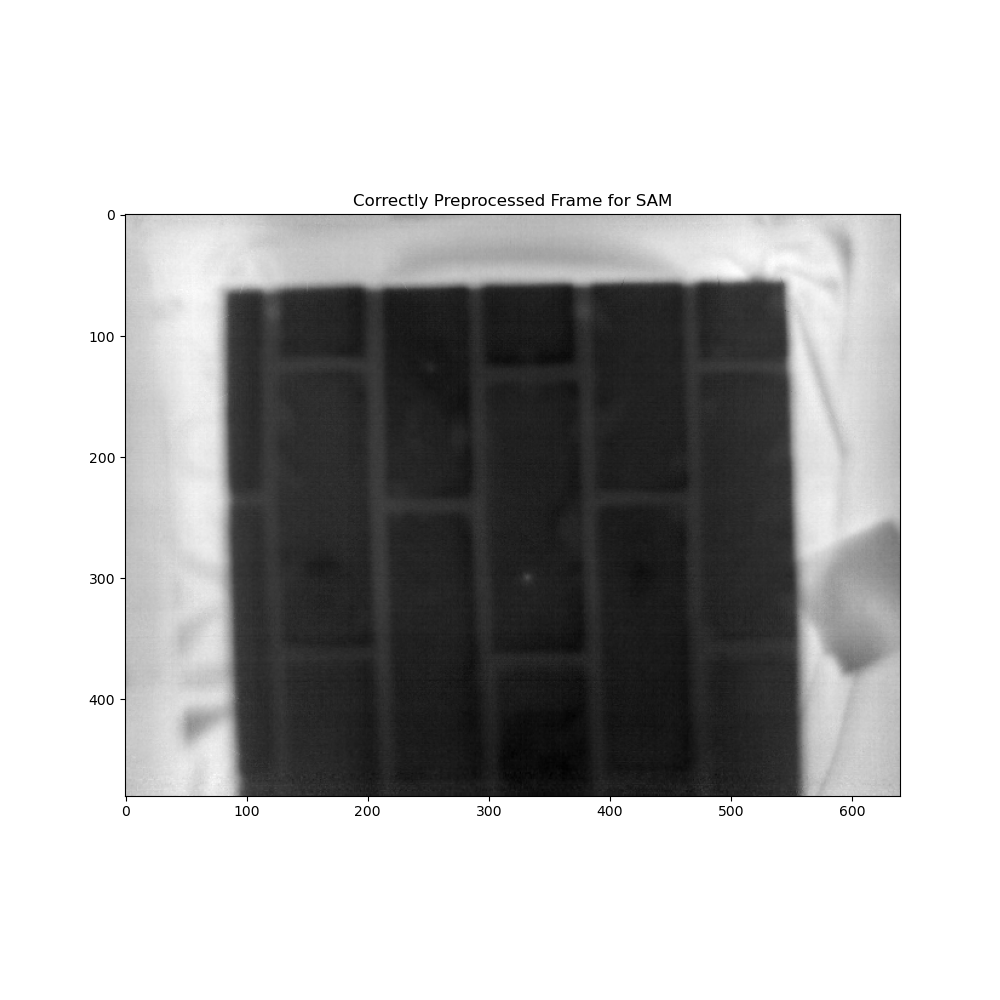

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [3]:
## using SAM
import os
import numpy as np
import scipy.io
import cv2
import torch
import matplotlib.pyplot as plt

from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

# 1. Load your .mat IR video and pick a representative frame (e.g. the median‐background or last frame)
mat_path = "/Users/shreyas/Desktop/UoU/Independent-Study/Airflow-rate-prediction/datasets/dataset_two_holes/T1.4V_2.2Pa_2025-6-16-16-34-30_20_34_14_.mat"
mat = scipy.io.loadmat(mat_path)
frames = mat["TempFrames"].astype(np.float32)        # (H, W, T)
background = np.median(frames, axis=2)                # static view
frame_rgb = cv2.cvtColor(background, cv2.COLOR_GRAY2RGB)

background = np.median(frames, axis=2)

# 3. --- FIX IS HERE: Normalize the float image to an 8-bit (0-255) image ---
# This step is crucial for visualization and for SAM's image encoder.
# It scales the lowest temperature in the 'background' to 0 and the highest to 255.
background_normalized_8bit = cv2.normalize(
    background, 
    None,                # No destination provided, function will create it
    alpha=0,             # Minimum value of the output range
    beta=255,            # Maximum value of the output range
    norm_type=cv2.NORM_MINMAX,
    dtype=cv2.CV_8U      # The output data type will be 8-bit unsigned integer
)
print("Normalized the background image from float to 8-bit (0-255).")

# 4. Convert the 8-bit grayscale image to a 3-channel RGB image
frame_rgb = cv2.cvtColor(background_normalized_8bit, cv2.COLOR_GRAY2RGB)
print(f"Converted normalized image to RGB format. Shape: {frame_rgb.shape}")

# --- Optional: Display the preprocessed frame to verify it looks correct ---
plt.figure(figsize=(10,10))
plt.imshow(frame_rgb)
plt.title("Correctly Preprocessed Frame for SAM")
plt.show()

# 2. Load SAM
device = "cuda" if torch.cuda.is_available() else "cpu"
sam_checkpoint = "/Users/shreyas/Desktop/UoU/Independent-Study/Airflow-rate-prediction/SAM/sam_checkpoints/sam_vit_b_01ec64.pth"
model_type     = "vit_b"
sam            = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)


Required variables 'sam', 'frame_rgb', and 'mat_path' found. Proceeding...

Running SAM in 'Segment Everything' mode... (This may take a moment)
SAM found 19 potential masks in 57.47 seconds.
Visualizing all generated masks...


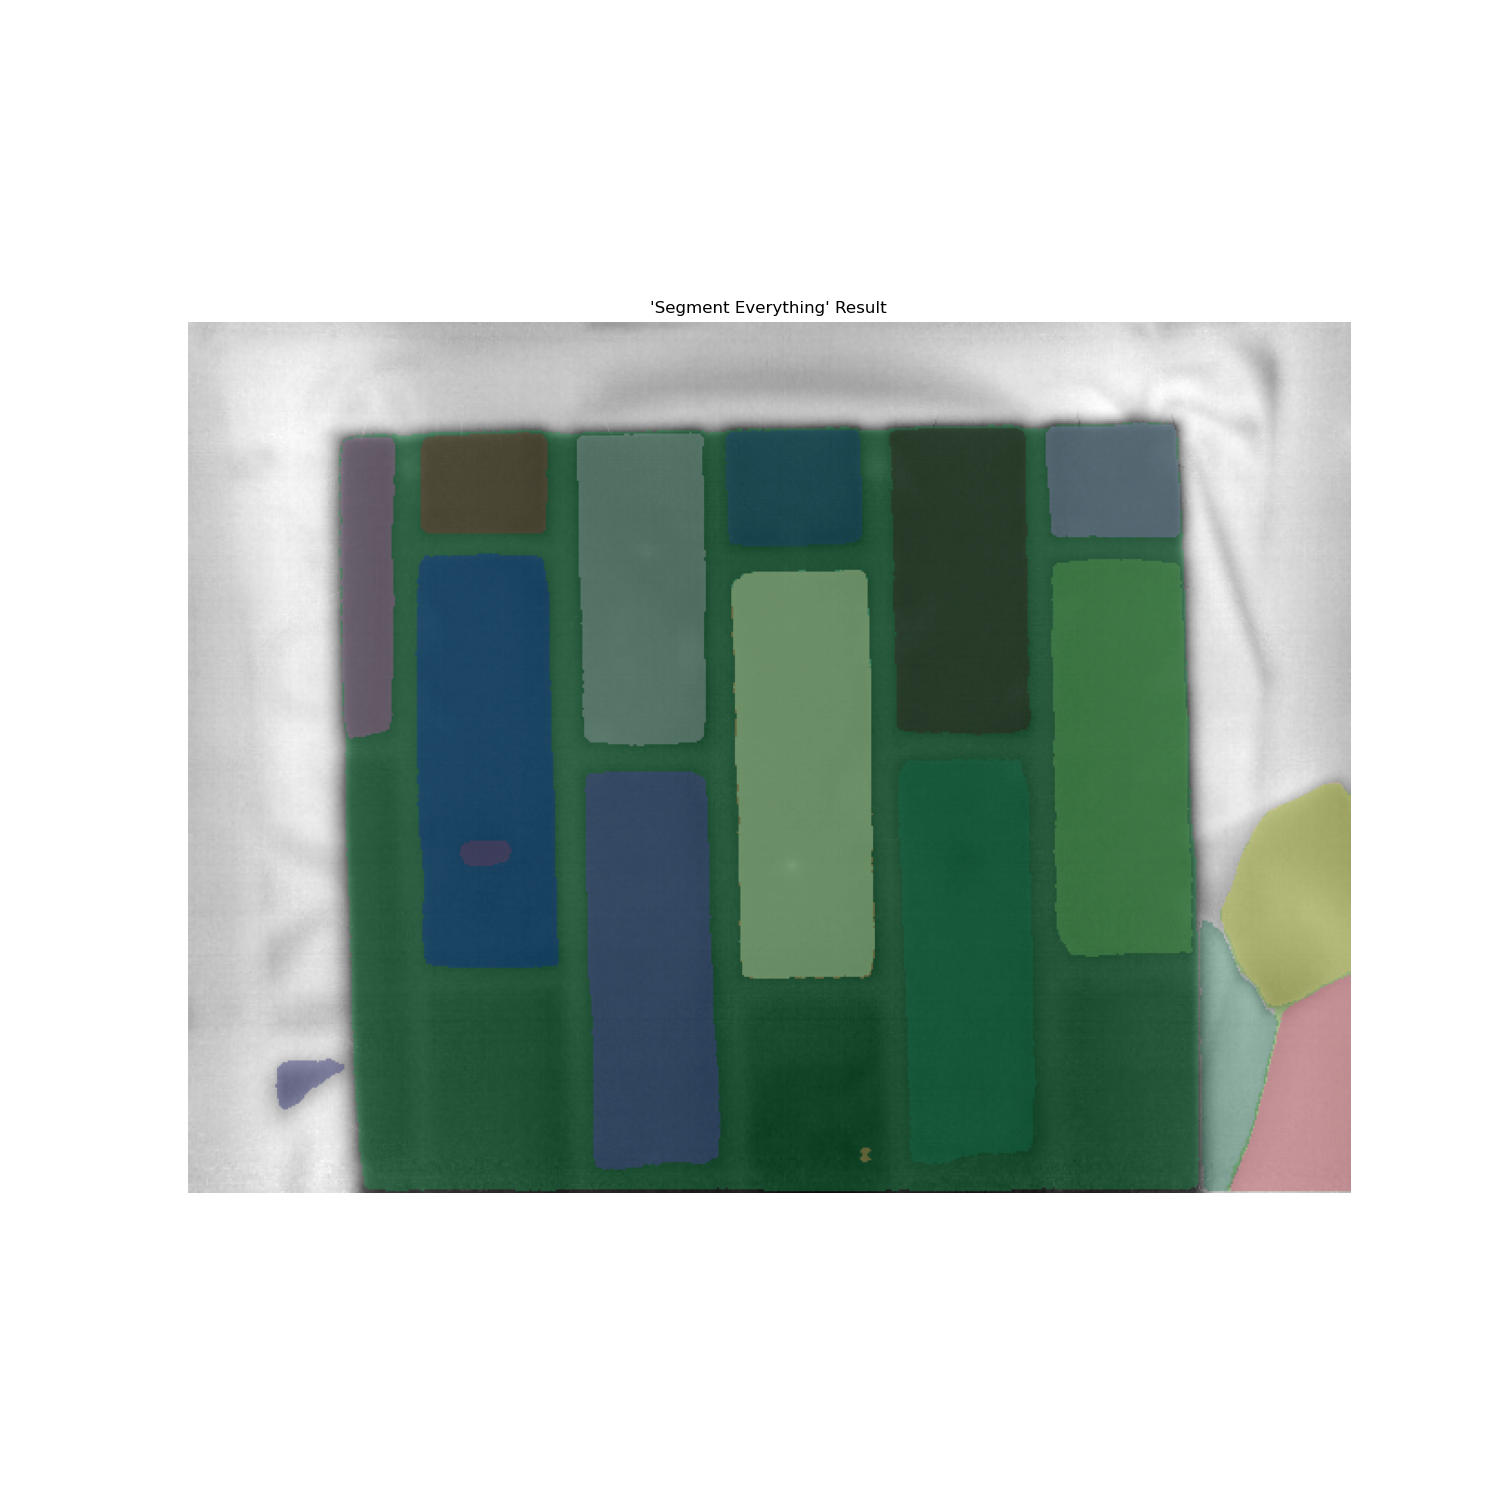


--- Data for the 5 largest masks found ---
Mask 1: Area = 194428, BBox = [83.0, 56.0, 473.0, 422.0], Predicted IoU = 0.924
Mask 2: Area = 16643, BBox = [125.0, 128.0, 78.0, 227.0], Predicted IoU = 0.880
Mask 3: Area = 16607, BBox = [299.0, 137.0, 78.0, 325.0], Predicted IoU = 0.885
Mask 4: Area = 16496, BBox = [299.0, 137.0, 78.0, 224.0], Predicted IoU = 0.914
Mask 5: Area = 15777, BBox = [475.0, 131.0, 77.0, 218.0], Predicted IoU = 0.883


In [4]:
# Cell for "Segment Everything" Test

import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
from segment_anything import SamAutomaticMaskGenerator

# --- Verify that necessary variables exist from previous cells ---
try:
    # These should be defined from your earlier cells
    _ = sam # Check if sam model is loaded
    _ = frame_rgb # Check if the preprocessed RGB image exists
    _ = mat_path # Check if the video path exists for titling
    print("Required variables 'sam', 'frame_rgb', and 'mat_path' found. Proceeding...")
except NameError as e:
    print(f"ERROR: A required variable is not defined: {e}")
    print("Please re-run the previous cells to load the SAM model and the image frame first.")

# --- Helper function to visualize all masks ---
def show_anns(anns, ax):
    if len(anns) == 0:
        return
    # Sort annotations by area so smaller masks are drawn on top of larger ones
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax.set_autoscale_on(False)

    # For each annotation, create a random color and overlay the mask
    for ann in sorted_anns:
        m = ann['segmentation']
        # Create a solid color image for this mask
        color_mask_img = np.ones((m.shape[0], m.shape[1], 3))
        color = np.random.random(3) # Generate a random color
        for i in range(3):
            color_mask_img[:,:,i] = color[i]
        
        # Apply the boolean mask to the color image and add an alpha channel for transparency
        # This creates an (H, W, 4) RGBA image for just this mask
        rgba_mask = np.dstack((color_mask_img, m * 0.35)) # 35% opacity
        ax.imshow(rgba_mask)


# --- Initialize the Automatic Mask Generator from the loaded SAM model ---
# You can tune these parameters later to see if it changes the result.
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,      # Denser grid of points to check
    pred_iou_thresh=0.86,    # Lower value -> more masks
    stability_score_thresh=0.92, # Lower value -> more masks
    min_mask_region_area=15, # Ignore tiny, probably noisy masks
)

# --- Run "Segment Everything" ---
print("\nRunning SAM in 'Segment Everything' mode... (This may take a moment)")
start_time = time.time()
masks = mask_generator.generate(frame_rgb)
end_time = time.time()
print(f"SAM found {len(masks)} potential masks in {end_time - start_time:.2f} seconds.")

# --- Visualize the results ---
print("Visualizing all generated masks...")
plt.figure(figsize=(15, 15))
ax = plt.gca() # Get the current axis

# 1. Show the original thermal image as the background
ax.imshow(frame_rgb)

# 2. Overlay all the found masks using the helper function
show_anns(masks, ax)

# 3. Set title and display
ax.set_title("'Segment Everything' Result")
ax.axis('off')
plt.show()

# --- Optional: Inspect the largest found masks ---
if len(masks) > 0:
    print("\n--- Data for the 5 largest masks found ---")
    # The list is already sorted by area inside show_anns, but we can re-sort here for clarity
    sorted_masks_by_area = sorted(masks, key=(lambda x: x['area']), reverse=True)
    for i, ann in enumerate(sorted_masks_by_area[:5]):
        print(f"Mask {i+1}: Area = {ann['area']}, BBox = {ann['bbox']}, Predicted IoU = {ann['predicted_iou']:.3f}")

In [ ]:
# using SAM with prompts

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import matplotlib.pyplot as plt
import numpy as np

# --- Re-use setup from previous cells ---
# Ensure you have 'sam', 'frame_rgb', and 'project_root' variables from before.
# If not, re-run those cells.
# sam_checkpoint_path = ...
# model_type = ...
# device = ...
# frame_rgb = ... (your preprocessed 3-channel image)

# --- Initialize the Automatic Mask Generator ---
# You can tune the parameters here later. Start with defaults.
mask_generator = SamAutomaticMaskGenerator(sam)

print("Running SAM in 'Segment Everything' mode... (This may take a minute)")
masks = mask_generator.generate(frame_rgb)
print(f"SAM found {len(masks)} potential masks!")

# The 'masks' variable is now a list of dictionaries. Let's inspect one.
if len(masks) > 0:
    print("\nExample of one mask's data:")
    sorted_masks = sorted(masks, key=lambda x: x['area'], reverse=True) # Sort by area
    print(sorted_masks[0]) # Print the largest mask's info

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import SamPredictor

# ==============================================================================
# Assume the following variables are already defined and loaded in your notebook:
#
# sam: The loaded SAM model object from sam_model_registry.
#      e.g., sam = sam_model_registry["vit_b"](checkpoint="path/to/checkpoint.pth")
#             sam.to(device="cpu") # or "cuda"
#
# frame_rgb: The single thermal frame you want to process, already converted to
#            a 3-channel RGB image (HxWx3) with uint8 data type (0-255).
#            e.g., frame_rgb = cv2.cvtColor(frame_normalized_8bit, cv2.COLOR_GRAY2BGR)
#
# ==============================================================================


# --- Helper functions for visualization ---
def show_mask(mask, ax, random_color=False):
    """Draws a single mask overlay on the given matplotlib axis."""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0) # RGBA with 60% opacity
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6]) # A nice blue with transparency
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    """Draws points on the given matplotlib axis."""
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    # Note: matplotlib's scatter uses (x, y) which matches our (col, row) convention
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def run_and_visualize_sam_with_prompts(sam_model, rgb_image, prompt_points, prompt_labels):
    """
    Initializes SAM predictor, runs prediction, and visualizes the output.
    
    Args:
        sam_model: The loaded SAM model object.
        rgb_image (np.ndarray): The HxWx3 uint8 image.
        prompt_points (np.ndarray): Array of (N, 2) with (x, y) coordinates.
        prompt_labels (np.ndarray): Array of (N,) with labels (1 for foreground).
    """
    # --- 1. Initialize the Interactive Predictor ---
    predictor = SamPredictor(sam_model)
    
    # Set the image for the predictor. This is a crucial step.
    predictor.set_image(rgb_image)
    print("Image set in SAM predictor.")

    # --- 2. Run Prediction ---
    print("Running SAM prediction with provided prompts...")
    masks, scores, logits = predictor.predict(
        point_coords=prompt_points,
        point_labels=prompt_labels,
        multimask_output=False, # Set to False to get only the single best mask per point
    )
    print(f"SAM generated {len(masks)} mask(s) with confidence scores: {scores}")

    # --- 3. Visualize the results ---
    plt.figure(figsize=(12, 12))
    ax = plt.gca() # Get the current axis
    
    # A. Draw the original thermal image as the background
    ax.imshow(rgb_image)
    
    # B. Overlay the generated masks
    print("Overlaying generated masks...")
    for i, (mask, score) in enumerate(zip(masks, scores)):
        show_mask(mask, ax, random_color=True)
        # Optional: Annotate score on the plot
        # centroid = np.mean(np.argwhere(mask), axis=0)
        # ax.text(centroid[1], centroid[0], f'{score:.2f}', color='white', fontsize=12, ha='center')

    # C. Show the prompt points that were used
    print("Overlaying prompt points...")
    show_points(prompt_points, prompt_labels, ax)
    
    ax.set_title(f"SAM Segmentation with Manual Point Prompts")
    ax.axis('off')
    plt.show()


# --- Main Execution Logic ---

# Manually define the prompt points based on your visual inspection
# These are (x, y) which means (column, row)
input_point_1 = np.array([[333, 298]])
input_point_2 = np.array([[251, 124]])

# Combine points and create corresponding labels
# Label '1' tells SAM that the point is on the object you want to segment (a foreground point)
input_points = np.concatenate([input_point_1, input_point_2], axis=0)
input_labels = np.array([1, 1]) 

# Call the main function to run the process
# This assumes 'sam' and 'frame_rgb' have been correctly loaded and defined in previous cells
try:
    if 'sam' in locals() and 'frame_rgb' in locals():
        run_and_visualize_sam_with_prompts(sam, frame_rgb, input_points, input_labels)
    else:
        print("Error: Please make sure the 'sam' model object and the 'frame_rgb' image array are loaded in previous cells.")
except NameError as e:
    print(f"A required variable is not defined. Please check your notebook cells. Error: {e}")

In [ ]:
import numpy as np
import cv2
import os
import scipy.io
import matplotlib.pyplot as plt
import fnmatch
import sys
from IPython.display import display, Image

from pathlib import Path

# Find the actual project root dynamically by looking for known files
current_path = Path.cwd()
while current_path != current_path.parent:
    if (current_path / "src" / "config.py").exists():
        project_root = str(current_path)
        break
    current_path = current_path.parent
else:
    raise FileNotFoundError("Could not locate project root containing 'src/config.py'.")

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

import config


In [ ]:
# --- Configuration: UPDATE THESE PATHS ---

# 1. Path to the root of the dataset containing the .mat files you want to check
#    e.g., your two-hole dataset
DATASET_TO_VERIFY = os.path.join(config.DATASET_PARENT_DIR, "dataset_two_holes")

# 2. Path to the directory where run_sam_segmentation.py saved the masks
#    This should be the *output_dir* you provided to that script.
MASK_DIRECTORY_TO_VERIFY = os.path.join(project_root, "output_SAM") # Example path

# 3. Path where you want to save the verification images
OUTPUT_VISUALIZATION_DIR = os.path.join(project_root, "verified_masks/SAM")

# --- Visualization Parameters ---
FRAME_TO_DISPLAY = -1 # Use -1 for the last frame, or 0 for the first, or any specific index
MAT_KEY = config.MAT_FRAMES_KEY
OVERLAY_COLOR = [0, 255, 255] # Yellow (BGR format)
OVERLAY_ALPHA = 0.4

# --- Create output directory ---
os.makedirs(OUTPUT_VISUALIZATION_DIR, exist_ok=True)
print(f"Dataset to verify: {DATASET_TO_VERIFY}")
print(f"Masks will be loaded from: {MASK_DIRECTORY_TO_VERIFY}")
print(f"Verification images will be saved to: {OUTPUT_VISUALIZATION_DIR}")

In [ ]:
def load_frames(mat_file_path, mat_key):
    """Loads frames from a .mat file."""
    try:
        mat_data = scipy.io.loadmat(mat_file_path)
        frames = mat_data[mat_key].astype(np.float64)
        return frames
    except Exception as e:
        print(f"  Error loading .mat {os.path.basename(mat_file_path)}: {e}")
        return None

def load_mask(mask_file_path):
    """Loads a boolean mask from a .npy file."""
    try:
        mask = np.load(mask_file_path)
        if mask.dtype != bool:
            mask = mask.astype(bool)
        return mask
    except Exception as e:
        print(f"  Error loading mask {os.path.basename(mask_file_path)}: {e}")
        return None

def create_and_save_overlay(base_frame_raw, mask, title, save_path):
    """Creates a blended overlay image and saves it."""
    if base_frame_raw is None or mask is None or base_frame_raw.shape != mask.shape:
        print(f"  Skipping overlay for {title} due to invalid inputs or shape mismatch.")
        return

    try:
        # Normalize the raw float frame to 8-bit for display
        base_image_normalized = cv2.normalize(base_frame_raw, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        base_image_bgr = cv2.cvtColor(base_image_normalized, cv2.COLOR_GRAY2BGR)
        
        # Create overlay layer
        overlay_color_layer = np.zeros_like(base_image_bgr)
        overlay_color_layer[mask] = OVERLAY_COLOR
        
        # Blend images
        blended_img = cv2.addWeighted(overlay_color_layer, OVERLAY_ALPHA, base_image_bgr, 1.0 - OVERLAY_ALPHA, 0)
        
        # Convert back to RGB for matplotlib
        img_rgb = cv2.cvtColor(blended_img, cv2.COLOR_BGR2RGB)

        # Plot and save
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        ax.imshow(img_rgb)
        ax.set_title(title, fontsize=10)
        ax.axis('off')
        plt.tight_layout()
        plt.savefig(save_path, dpi=150)
        plt.close(fig)
        
    except Exception as e:
        print(f"  Error creating or saving overlay image for {title}: {e}")

In [ ]:
print("--- Starting Mask Verification Process ---")

processed_count = 0
skipped_mat_count = 0
skipped_mask_count = 0

# Walk through the dataset directory to find .mat files
for root, _, files in os.walk(DATASET_TO_VERIFY):
    # Determine relative path for constructing output/mask paths
    relative_dir = os.path.relpath(root, DATASET_TO_VERIFY)
    if relative_dir == '.':
        relative_dir = ''

    print(f"\nScanning directory: {os.path.join(DATASET_TO_VERIFY, relative_dir)}")

    for mat_filename in fnmatch.filter(files, '*.mat'):
        mat_file_path = os.path.join(root, mat_filename)
        mat_filename_no_ext = os.path.splitext(mat_filename)[0]

        # Construct the expected path to the mask generated by run_sam_segmentation.py
        # It uses a different naming convention, e.g., "_sam_mask.npy"
        mask_filename = f"{mat_filename_no_ext}_sam_mask.npy"
        expected_mask_path = os.path.join(MASK_DIRECTORY_TO_VERIFY, mask_filename)

        if not os.path.exists(expected_mask_path):
            # print(f"  Mask not found for {mat_filename} at {expected_mask_path}. Skipping.")
            skipped_mask_count += 1
            continue
        
        # Load frames and mask
        frames = load_frames(mat_file_path, MAT_KEY)
        if frames is None:
            skipped_mat_count += 1
            continue
            
        mask = load_mask(expected_mask_path)
        if mask is None:
            skipped_mask_count += 1
            continue

        # Choose which frame to display the mask on
        frame_to_display = frames[:, :, FRAME_TO_DISPLAY]

        # Prepare paths and titles
        output_vis_subdir = os.path.join(OUTPUT_VISUALIZATION_DIR, relative_dir)
        os.makedirs(output_vis_subdir, exist_ok=True)
        save_path = os.path.join(output_vis_subdir, f"{mat_filename_no_ext}_sam_mask_verify.png")
        title = f"{relative_dir}/{mat_filename}\nOverlay on Frame {FRAME_TO_DISPLAY}"
        
        # Create and save the overlay image
        create_and_save_overlay(frame_to_display, mask, title, save_path)
        
        # Display the saved image directly in the notebook for instant feedback
        display(Image(filename=save_path, width=400))
        
        processed_count += 1

print("\n--- Verification Finished ---")
print(f"Successfully generated visualizations for: {processed_count} files.")
print(f"Skipped (missing .mat or load error): {skipped_mat_count} files.")
print(f"Skipped (missing .npy mask or load error): {skipped_mask_count} files.")